In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re 

In [2]:
sns.set_context("poster")
sns.set_style("whitegrid")

In [3]:
def normalize_names(string):
    return string.replace("org.tastytruffle.benchmarks.ListBenchmark.benchmarkGraal", "List.") \
                 .replace("org.tastytruffle.benchmarks.ResizableArrayBenchmark.benchmarkGraal", "ArrayBuffer.") \
                 .replace("org.tastytruffle.benchmarks.ListBenchmark.benchmarkTruffle", "List.") \
                 .replace("org.tastytruffle.benchmarks.ResizableArrayBenchmark.benchmarkTruffle", "ArrayBuffer.")

def extract_types(string):
    pattern = r'^(List|ArrayBuffer)\.(Int|Long|Double)(.+)$'
    match = re.fullmatch(pattern, string)
    return match[2]

def drop_types_from_name(string):
    pattern = r'^(List|ArrayBuffer)\.(Int|Long|Double)(.+)$'
    match = re.fullmatch(pattern, string)
    return match[1] + '.' + match[3]

def canonicalize(df):
    df['Benchmark'] = df['Benchmark'].apply(normalize_names)
    df['Type'] = df['Benchmark'].apply(extract_types)
    df['Benchmark'] = df['Benchmark'].apply(drop_types_from_name)
    return df

In [4]:
data_files = [
    ("graal_results.csv", "Graal"),
    ("unspecialized_results.csv", "Mono"),
    ("specialized_results.csv", "Poly")
]

data = pd.DataFrame()
for (f, cat) in data_files:
    df = pd.read_csv(f)
    df["Origin"] = cat
    df['Normalized Score'] = df['Score'] / df['Param: arraySize']
    data = pd.concat([data, df]).drop_duplicates().reset_index(drop=True)

canonicalize(data)

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: arraySize,Origin,Normalized Score,Type
0,List.Append,thrpt,1,20,848.282514,9.105671,ops/s,100000,Graal,8.482825e-03,Double
1,List.Append,thrpt,1,20,69.675153,0.846113,ops/s,1000000,Graal,6.967515e-05,Double
2,List.Append,thrpt,1,20,0.222602,0.055778,ops/s,10000000,Graal,2.226020e-08,Double
3,List.Contains,thrpt,1,20,237.905193,3.786252,ops/s,100000,Graal,2.379052e-03,Double
4,List.Contains,thrpt,1,20,0.527383,0.046416,ops/s,1000000,Graal,5.273830e-07,Double
...,...,...,...,...,...,...,...,...,...,...,...
805,ArrayBuffer.Contains,thrpt,1,10,0.357412,0.056379,ops/s,5000000,Poly,7.148240e-08,Long
806,ArrayBuffer.Contains,thrpt,1,10,0.166578,0.003007,ops/s,7500000,Poly,2.221040e-08,Long
807,ArrayBuffer.Reverse,thrpt,1,10,246.932899,4.039643,ops/s,2500000,Poly,9.877316e-05,Long
808,ArrayBuffer.Reverse,thrpt,1,10,119.573687,14.591364,ops/s,5000000,Poly,2.391474e-05,Long


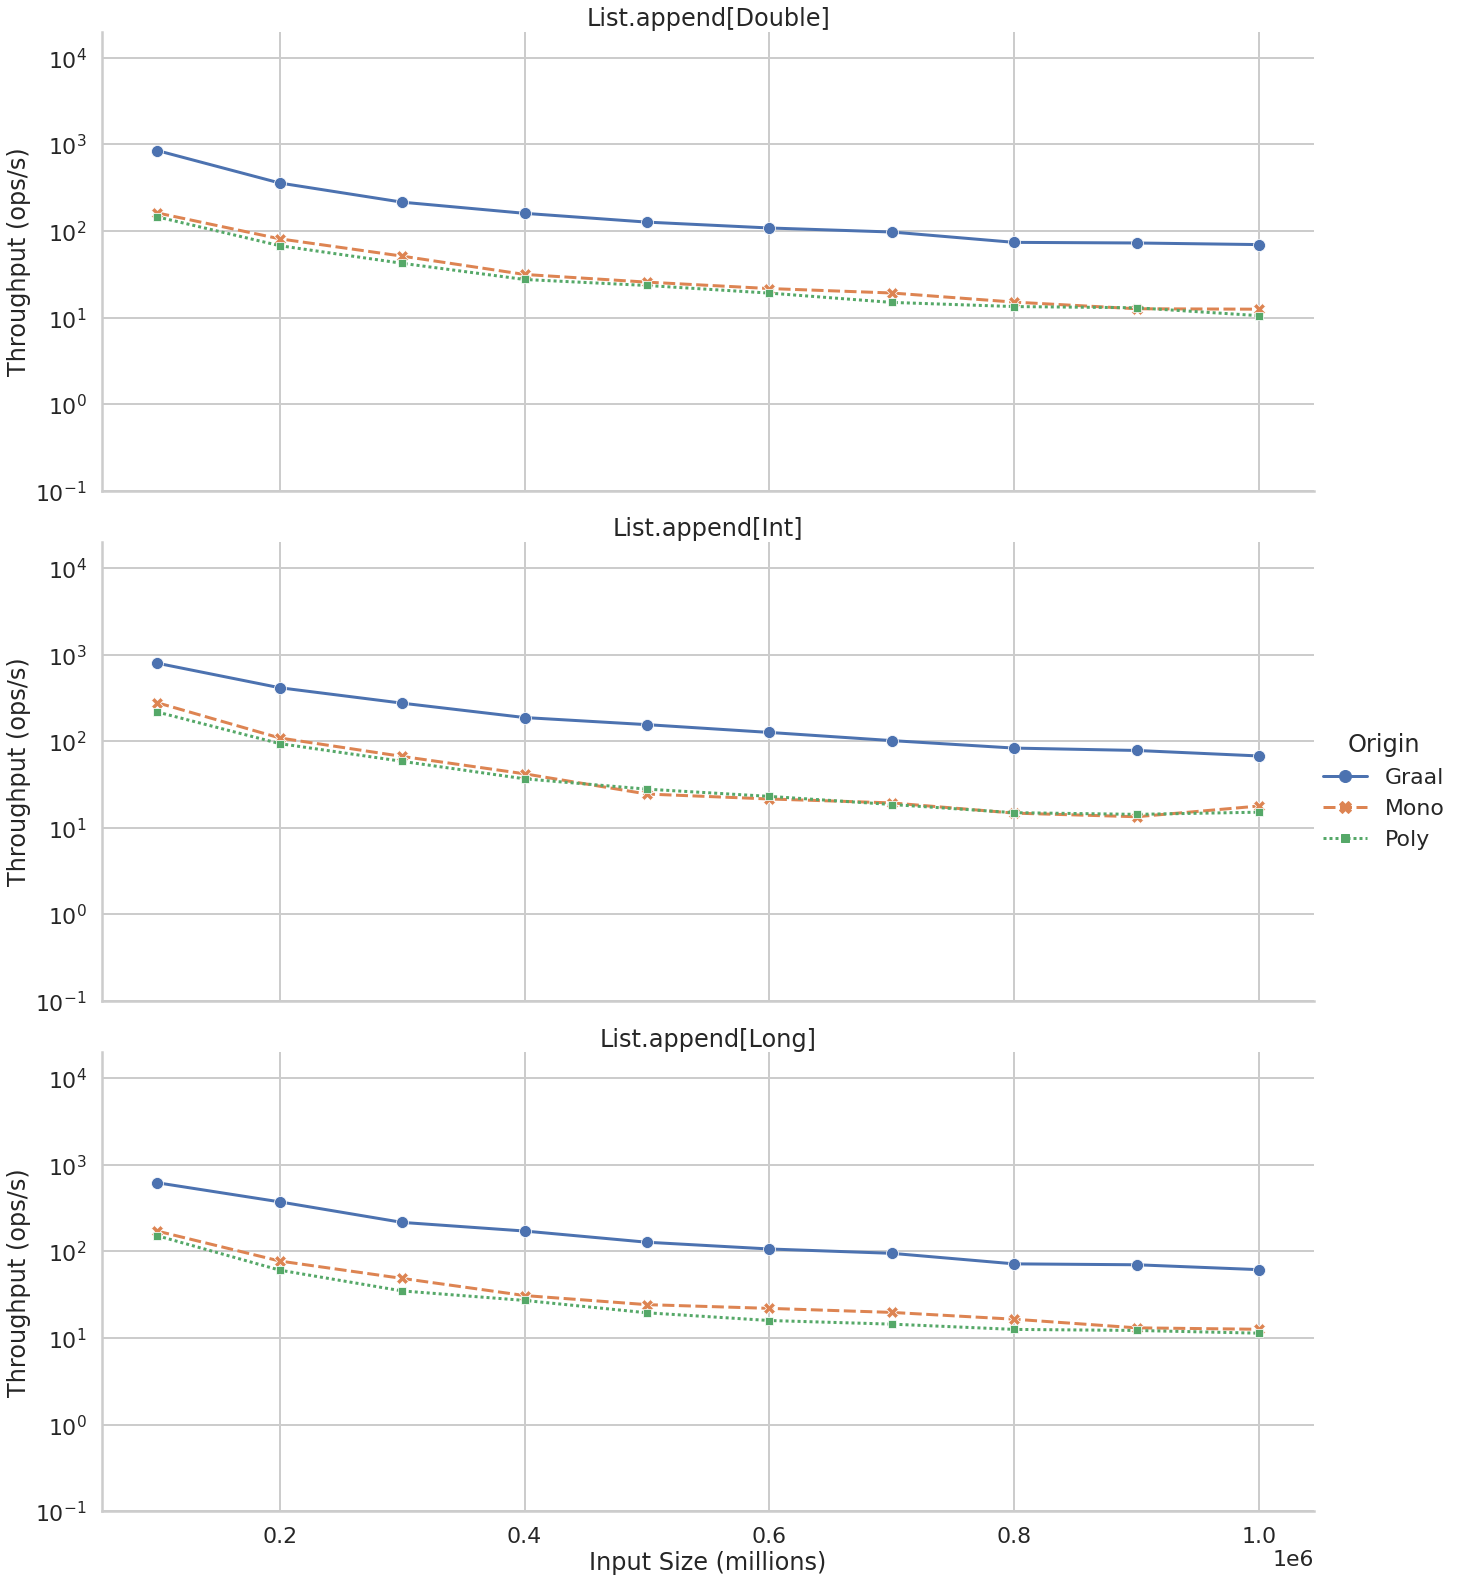

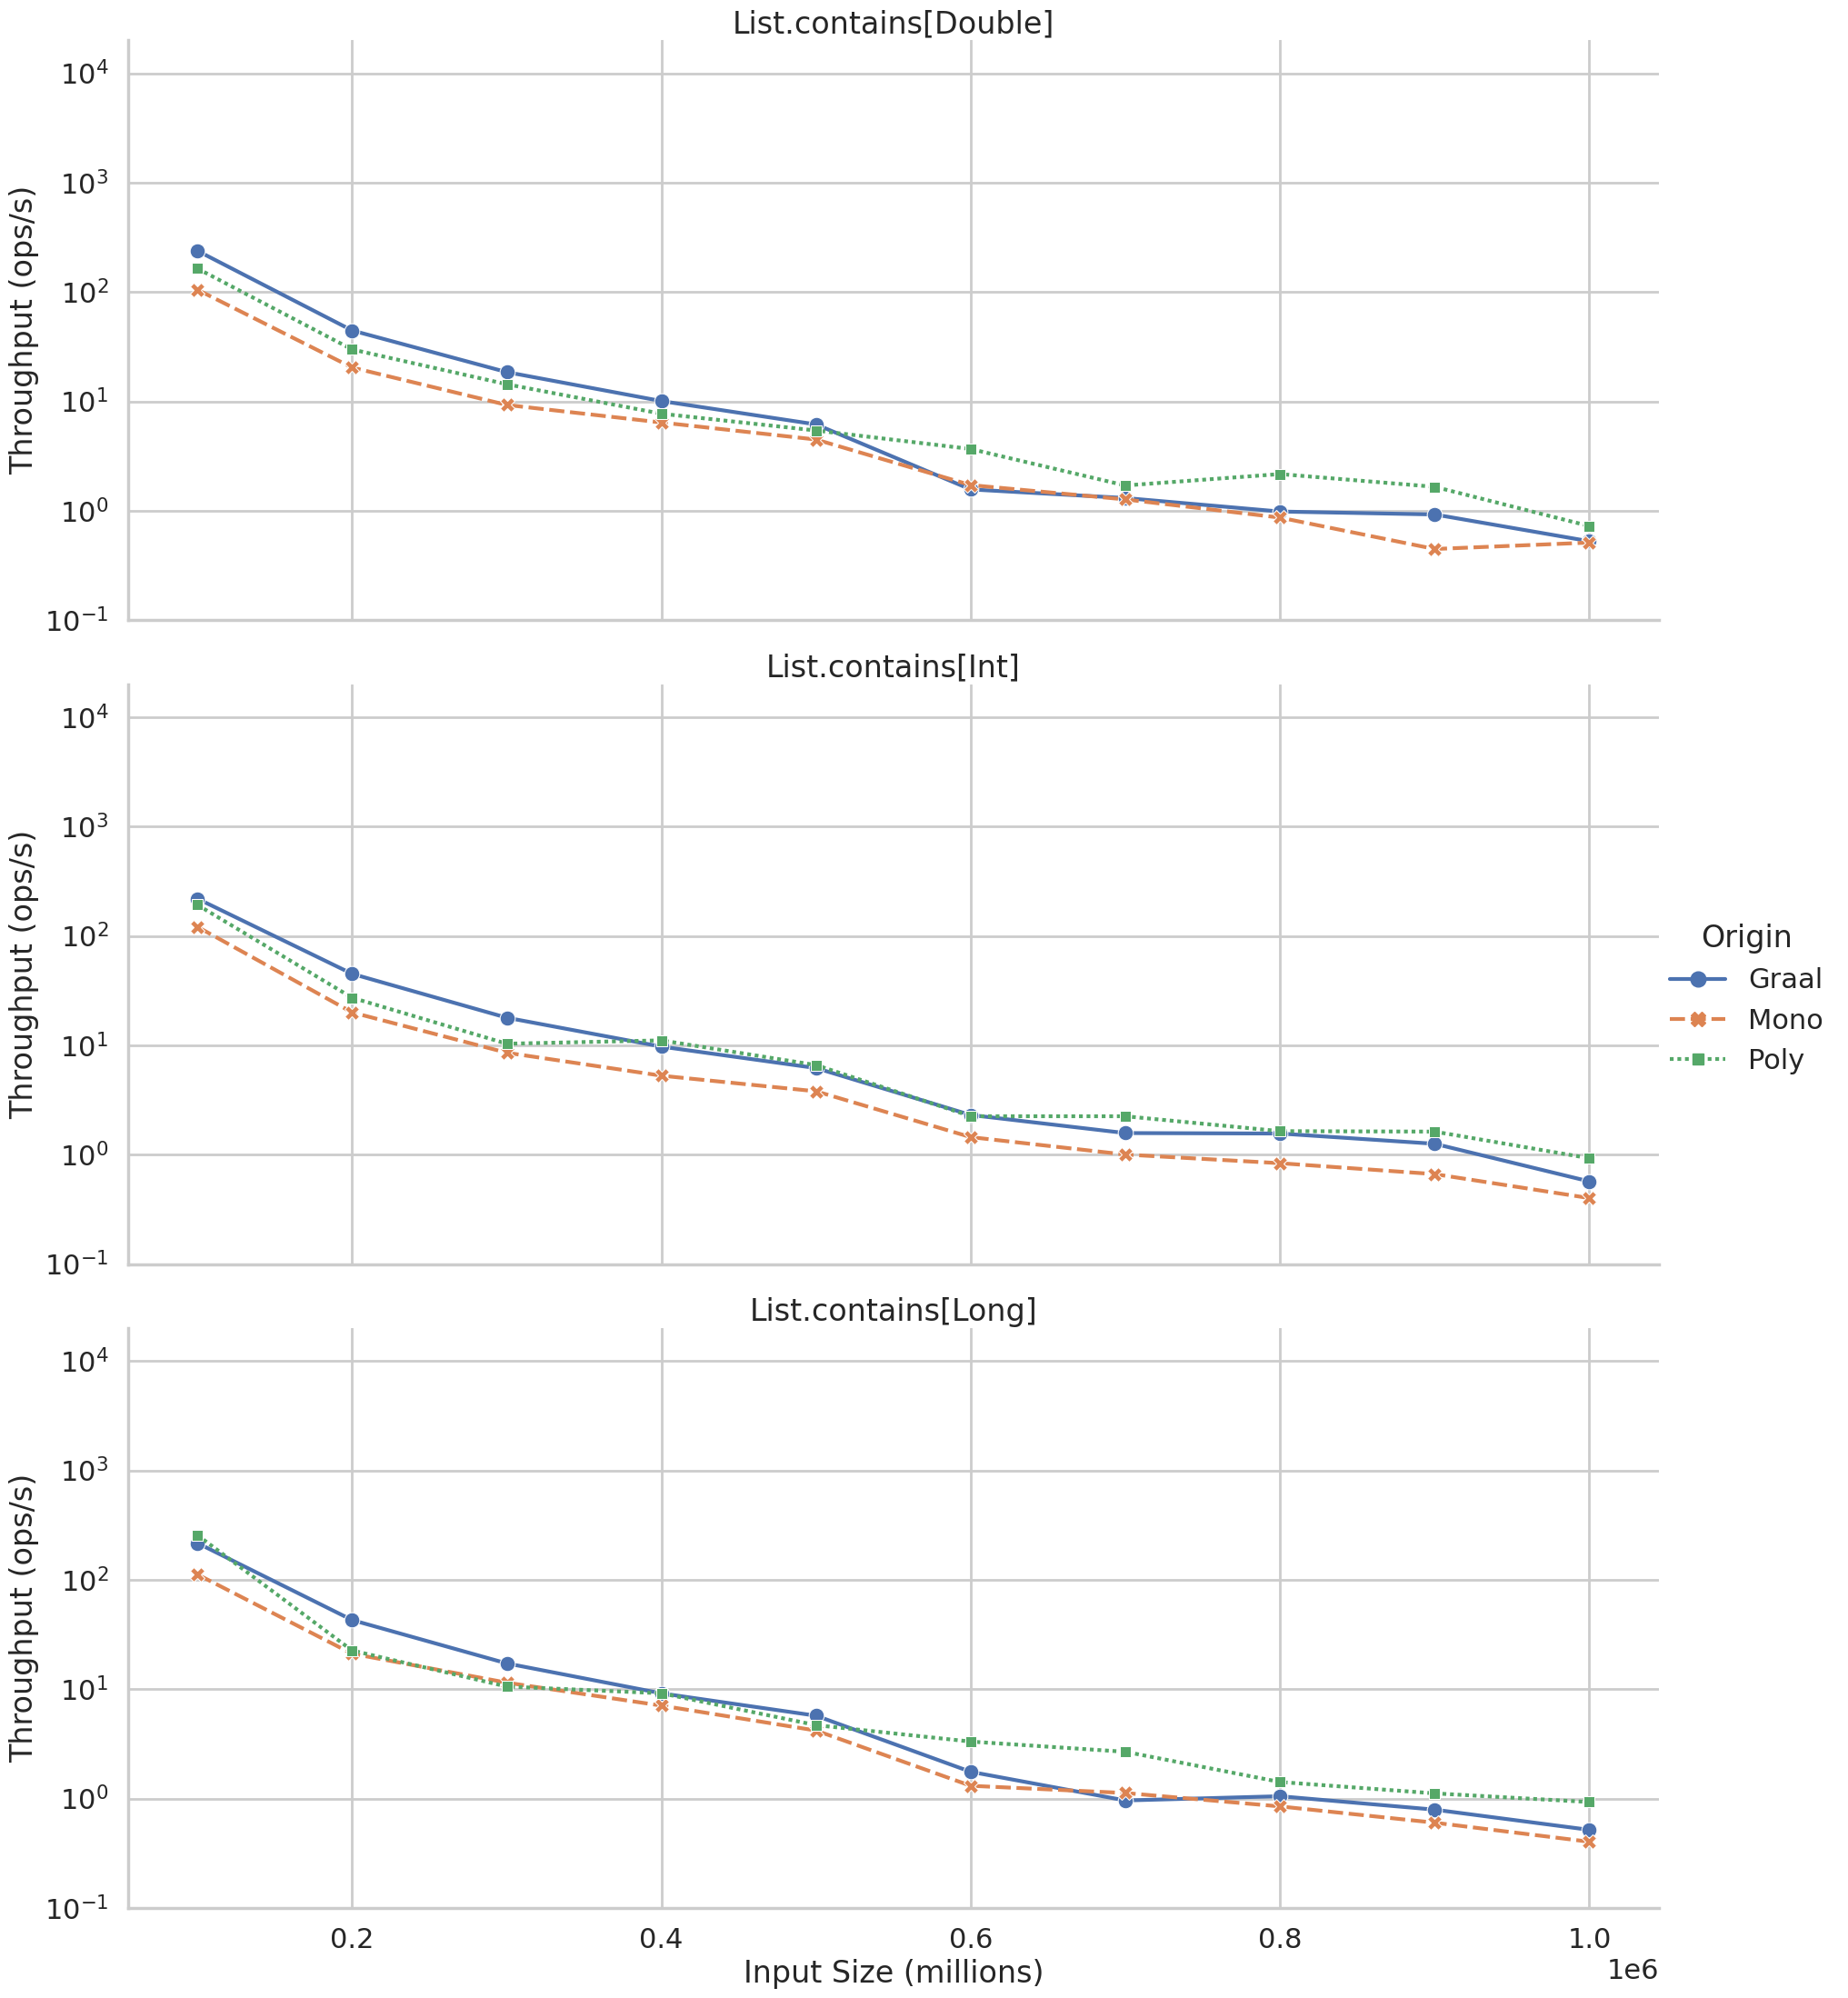

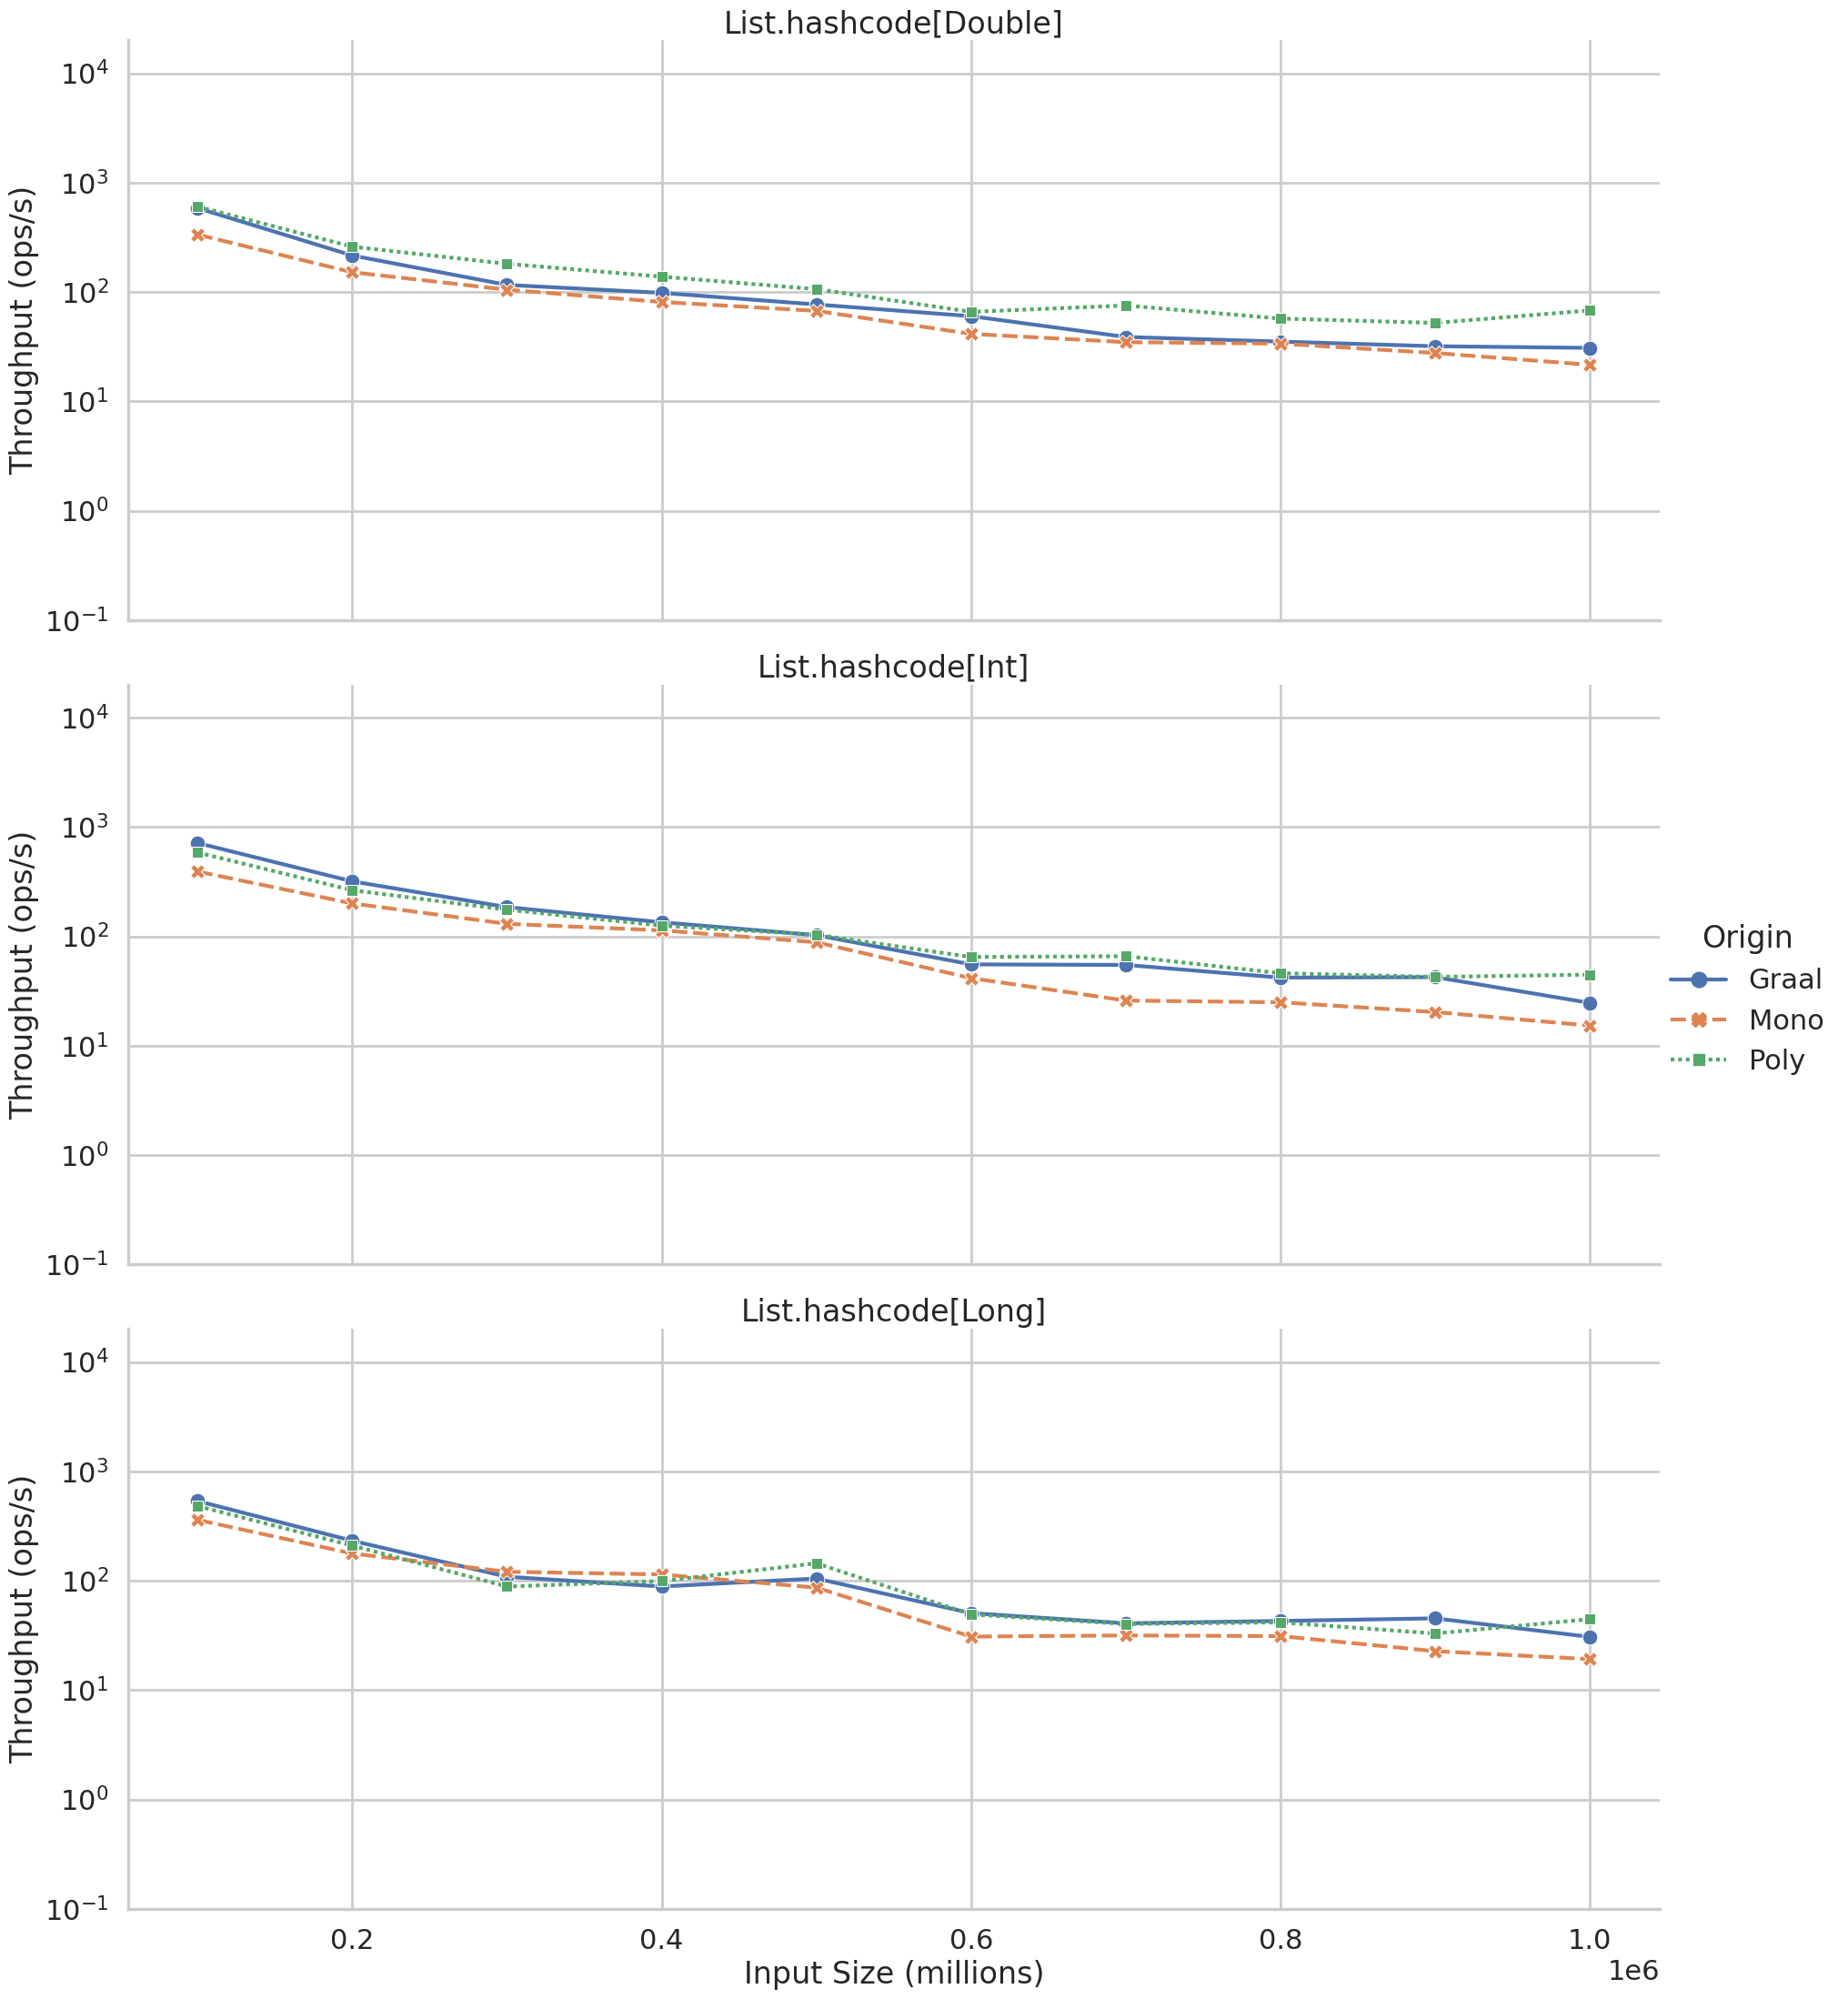

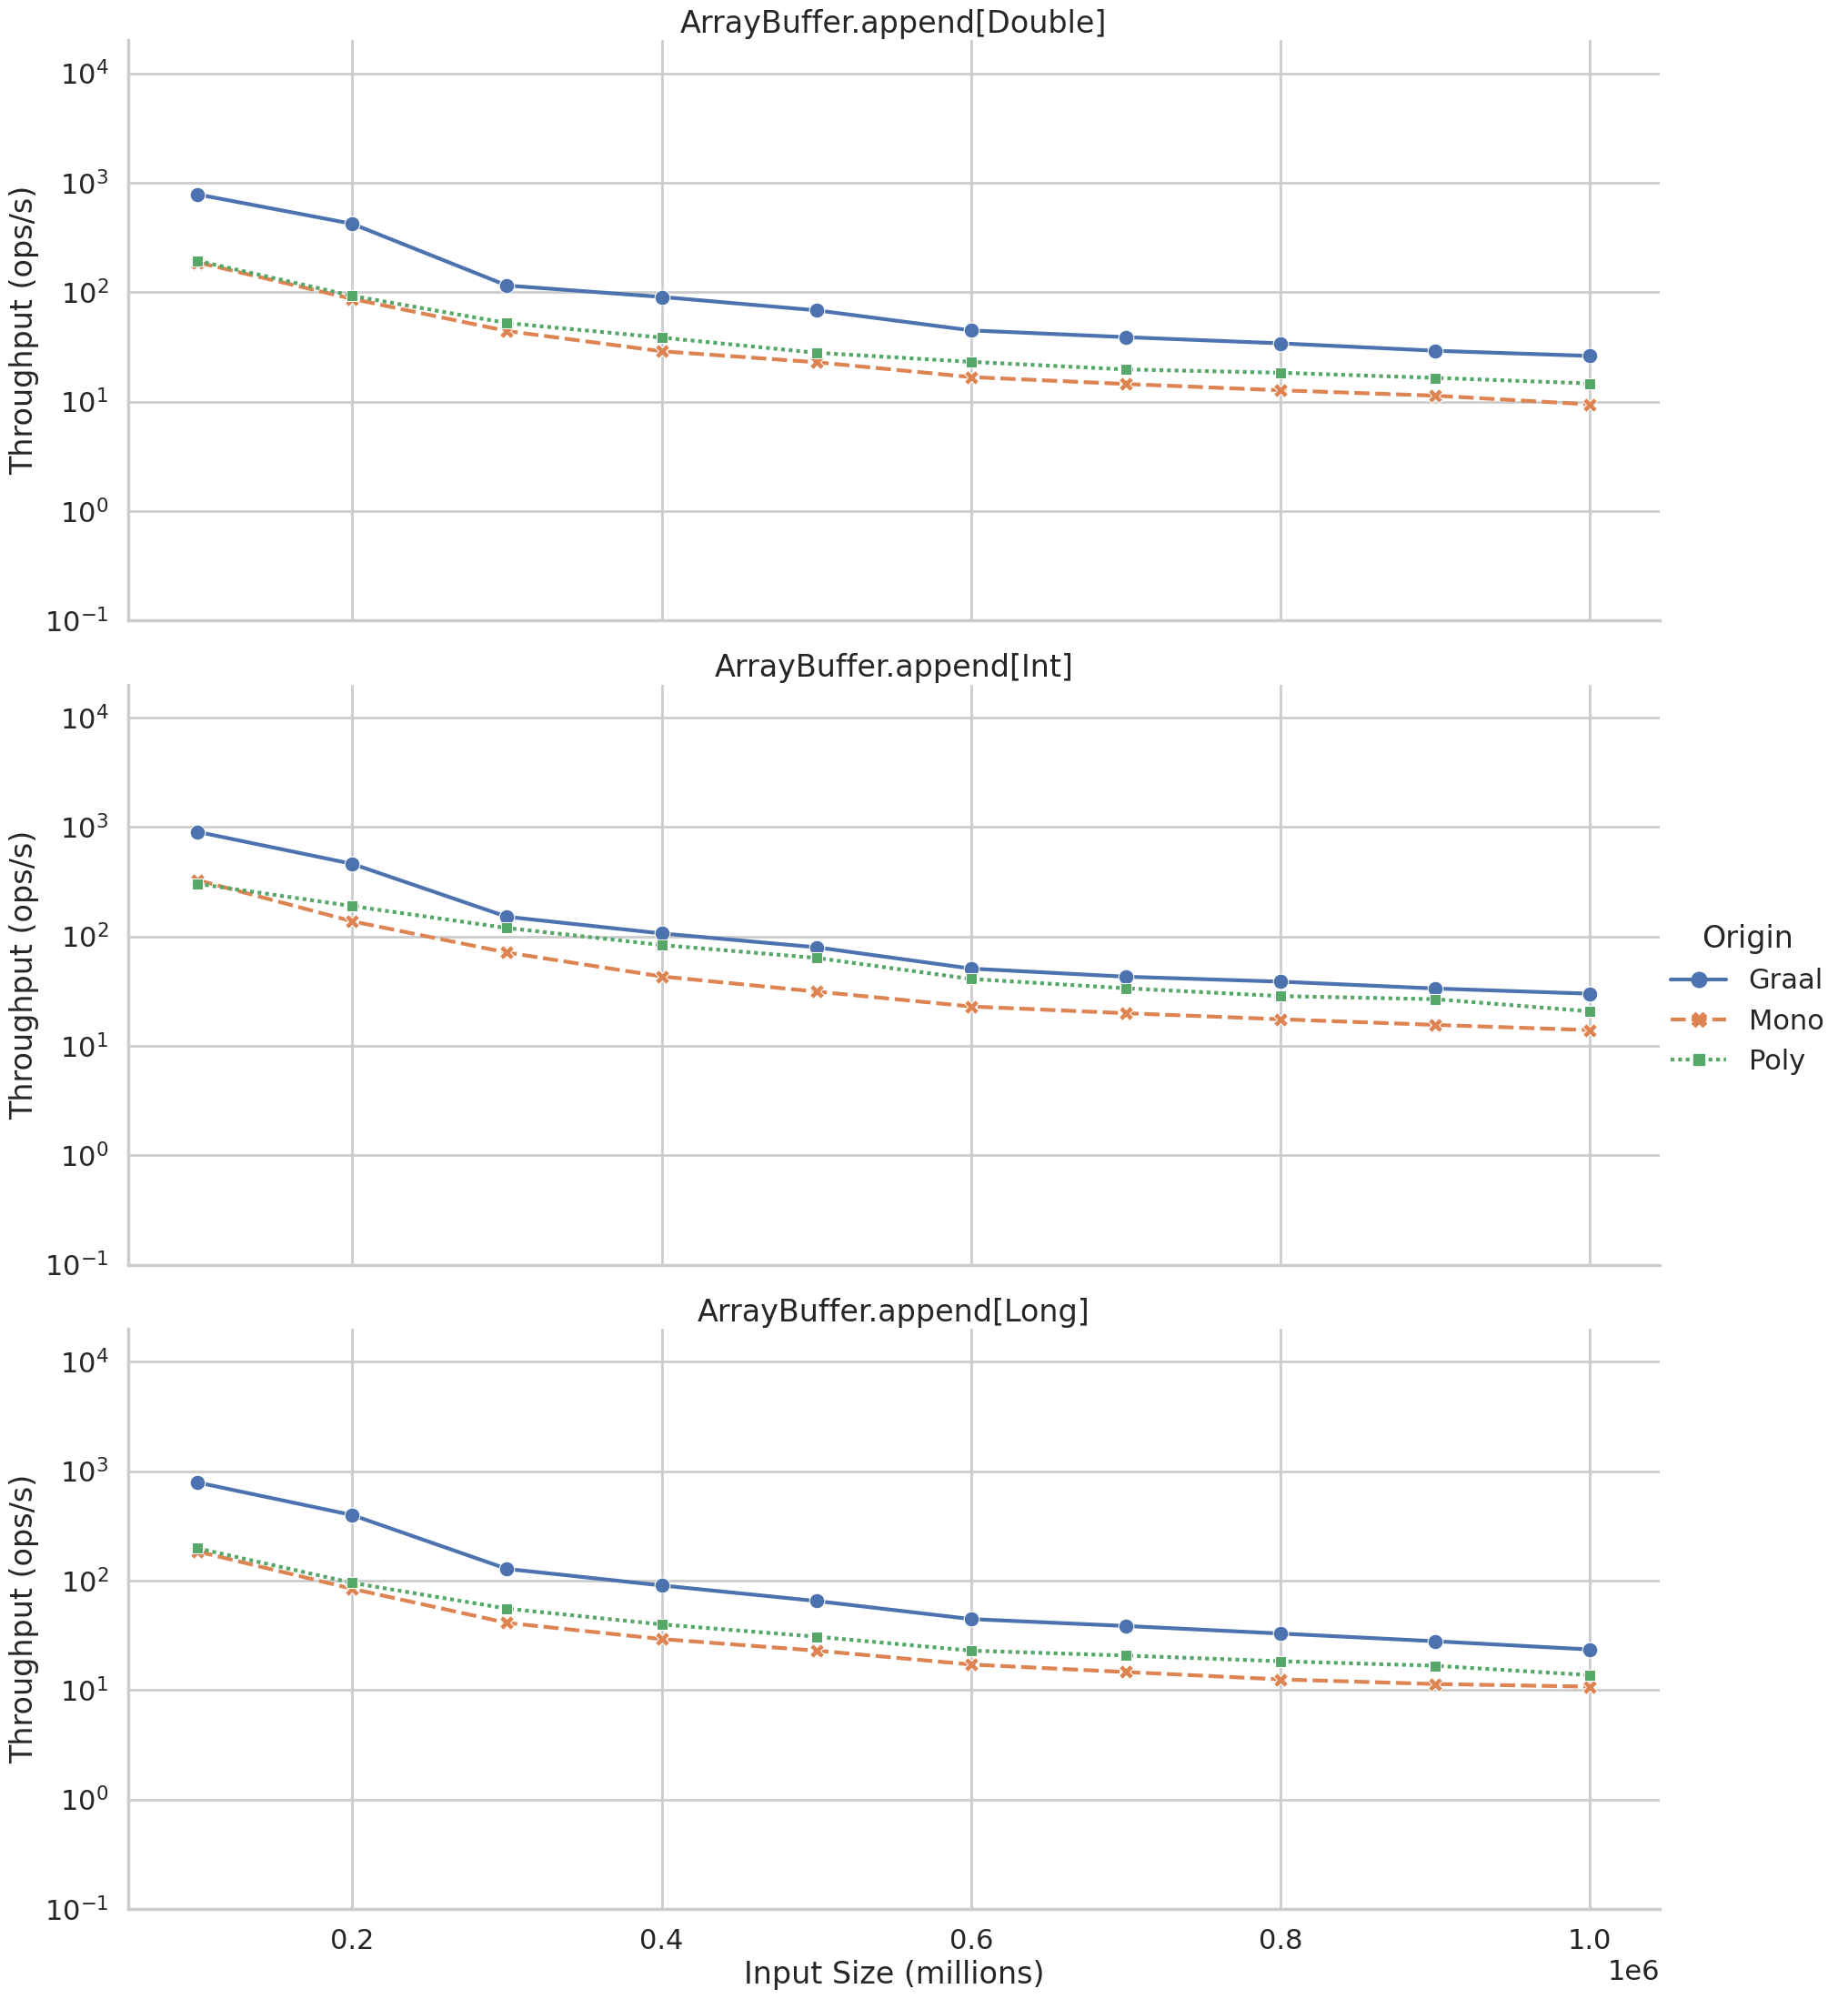

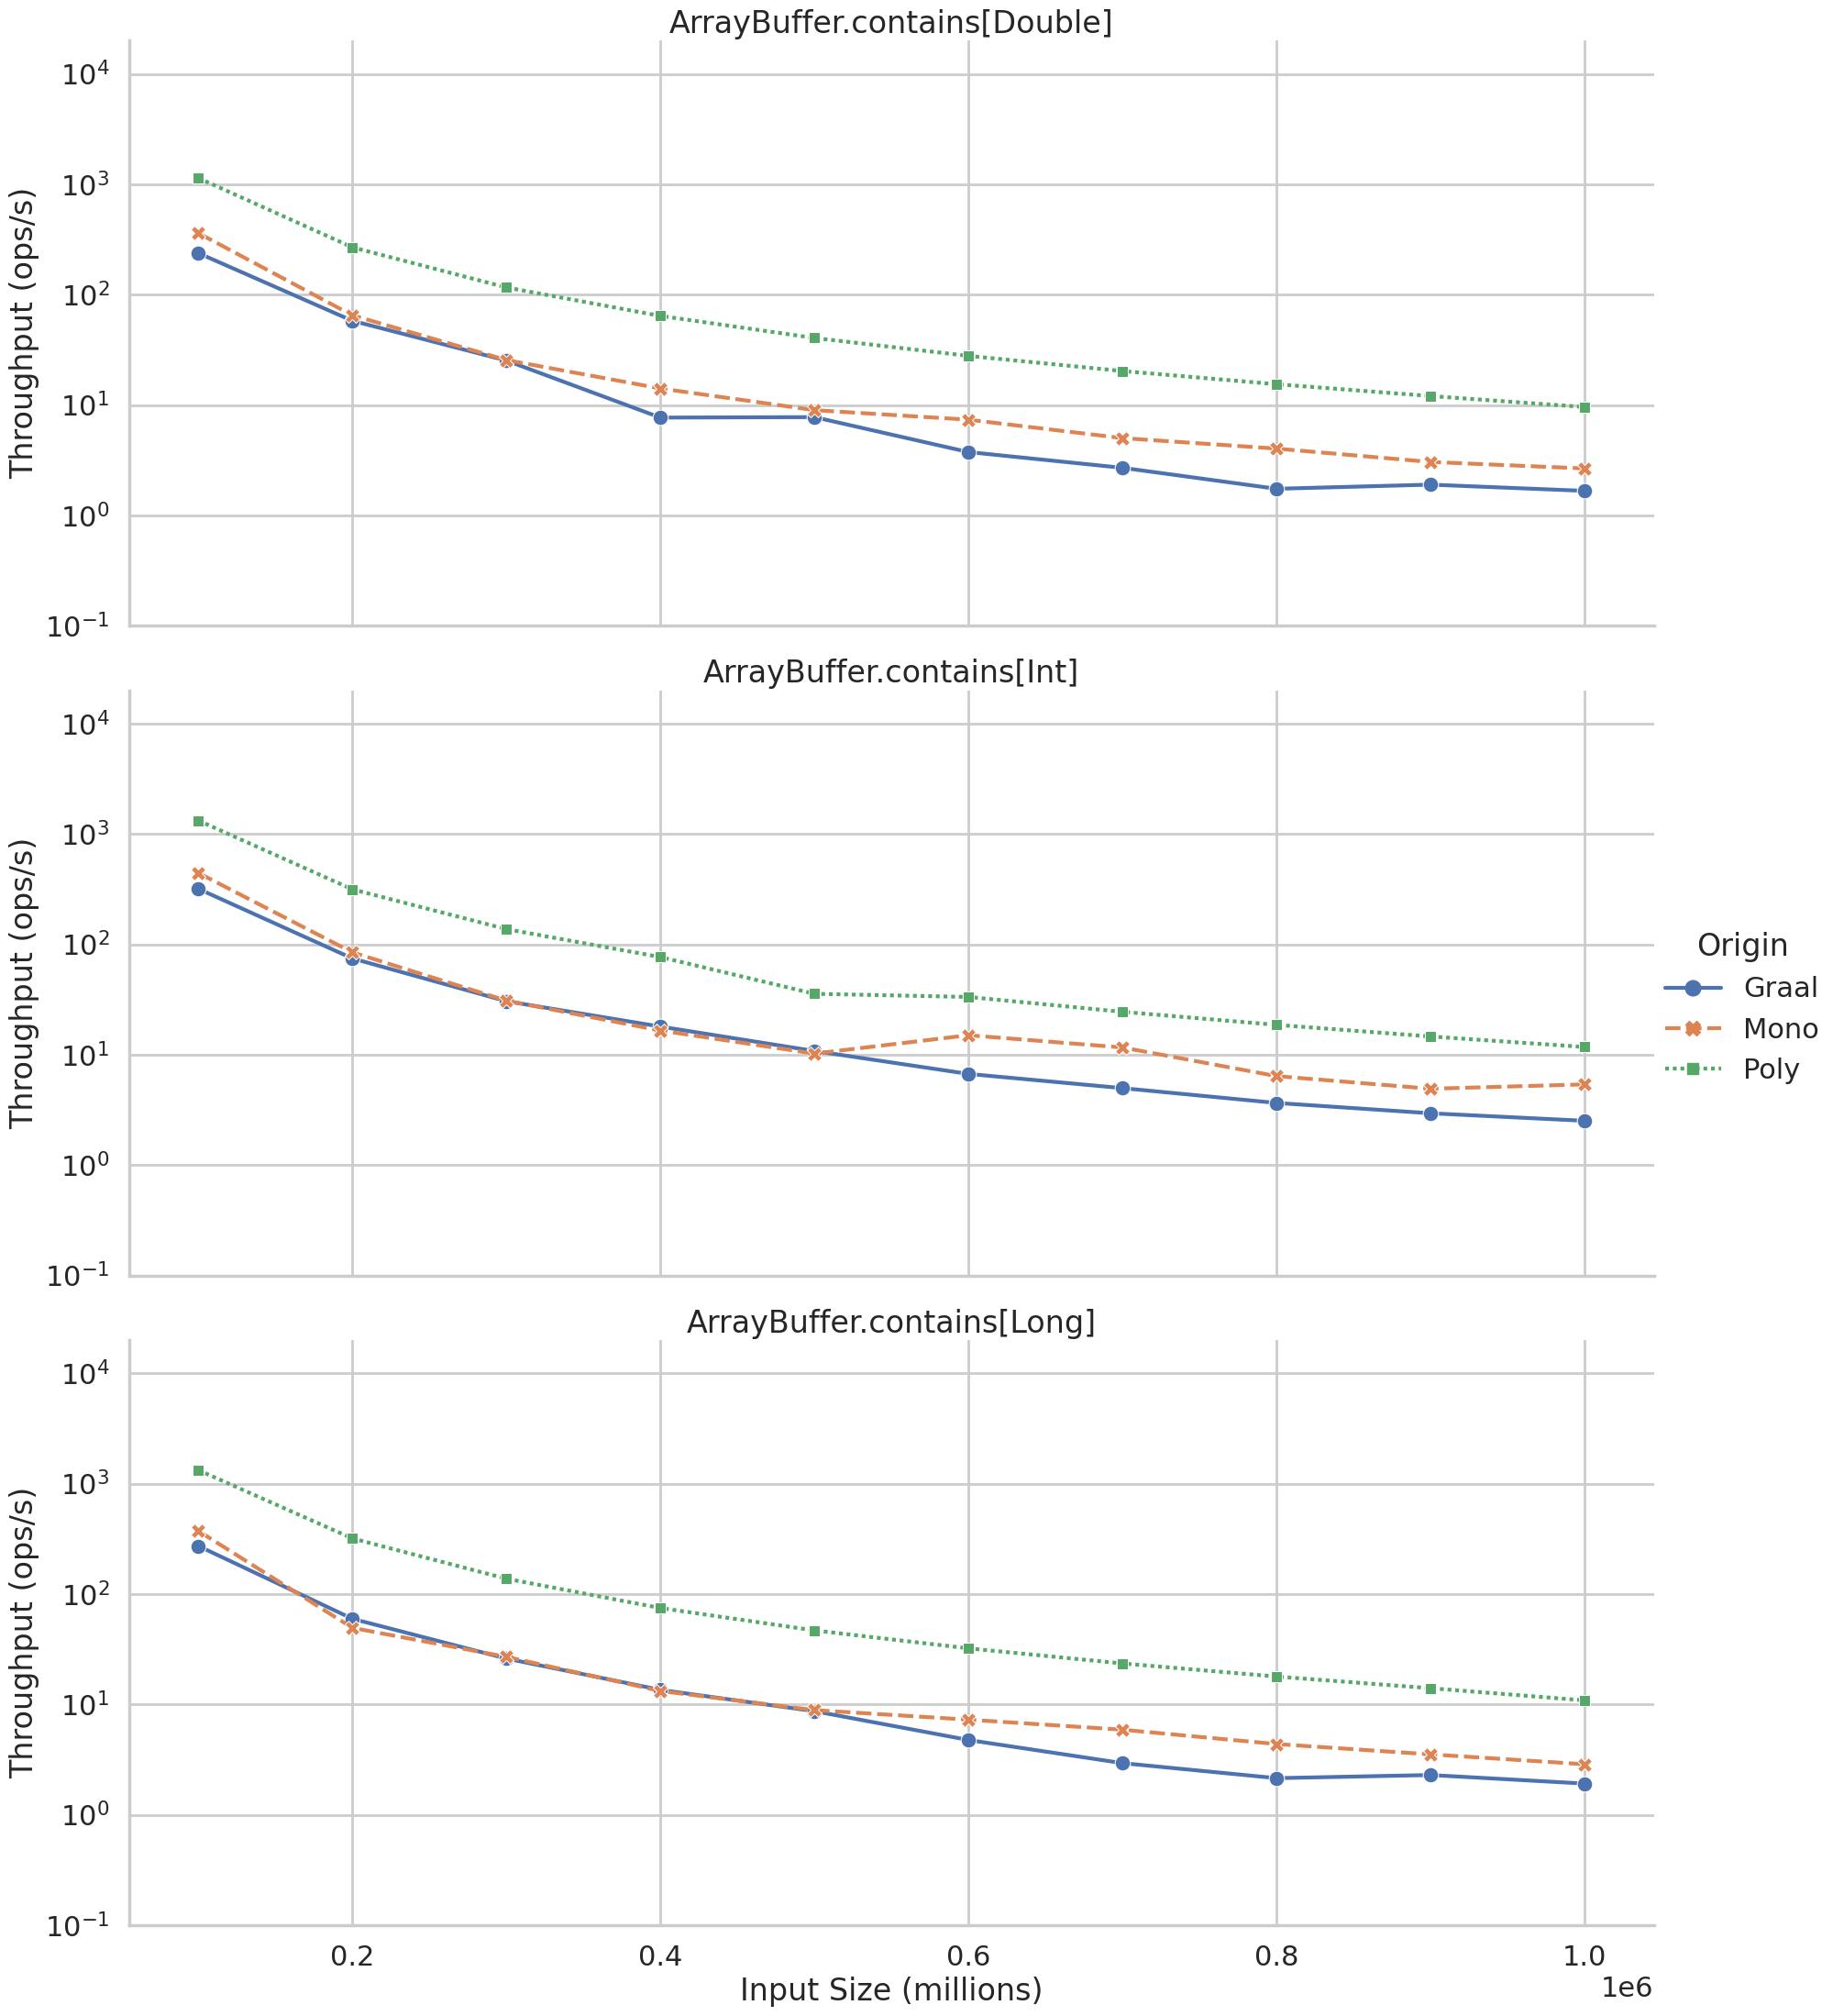

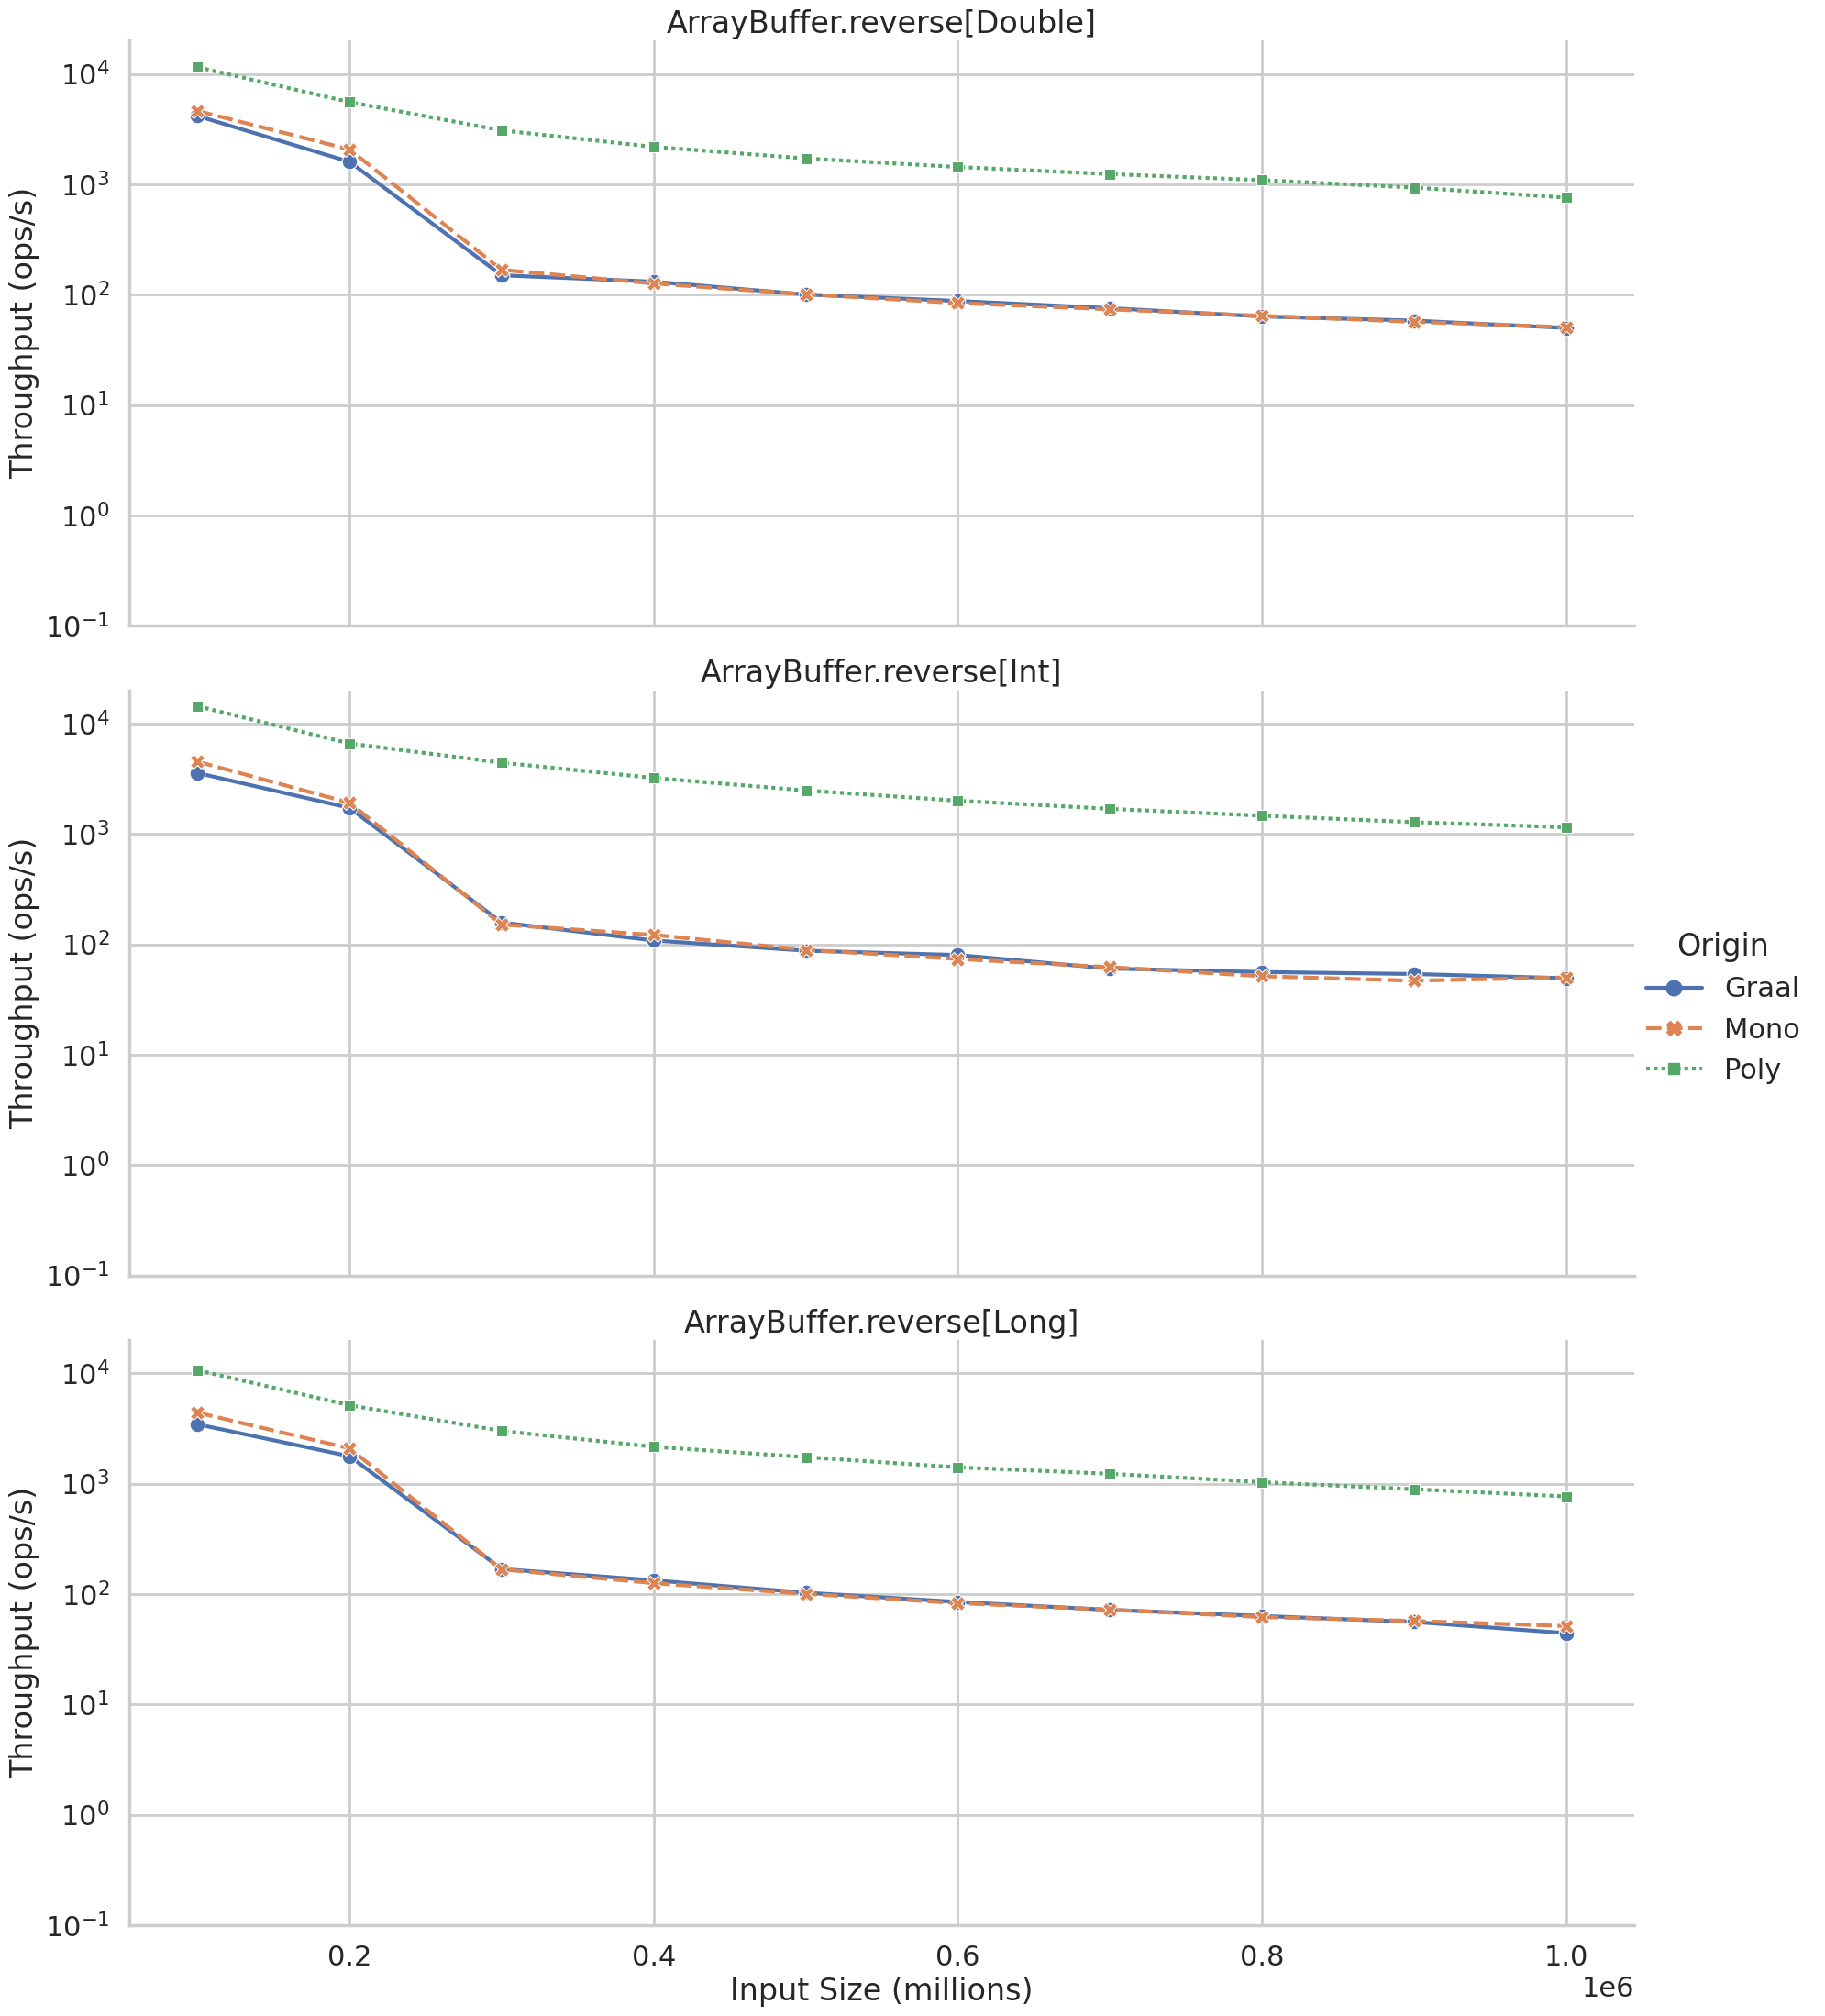

In [5]:
benchmarks = [
    "List.Append",
    "List.Contains",
    "List.Hashcode",
    "ArrayBuffer.Append",
    "ArrayBuffer.Contains",
    "ArrayBuffer.Reverse"
]

for b in benchmarks:
    components = b.split('.')
    cls = components[0]
    method = components[1]
    
    subset = data.loc[(data['Benchmark'] == b) & (data['Param: arraySize'] <= 10**6)]
    splot = sns.relplot(
            data=subset,
            row='Type',
            x="Param: arraySize", 
            y="Score",
            hue="Origin",
            style="Origin",
            kind="line",
            legend="full",
            markers=True,
            palette='deep',
            height=7.5,
            aspect=2.5
        )
    splot.set(yscale="log") 
    splot.set_axis_labels("Input Size (millions)", "Throughput (ops/s)") 
    splot.set_titles(cls + "." + method.lower()+"[{row_name}]")
   #  splot.figure.subplots_adjust(wspace=0, hspace=0)
    plt.ylim(0.1, 20000)
    # plt.ylim(subset['Score'].min() - 0.1, subset['Score'].max() + 10)
    plt.savefig(b + '.svg')
    plt.show()